In [1]:
# Este bloque define las ciudades y una función para calcular la distancia entre dos ciudades.
# Es el mismo que en el ejemplo anterior.

# Importamos el módulo 'math' para poder usar la función de raíz cuadrada (sqrt).
import math

# Definimos nuestras ciudades con sus coordenadas (x, y).
ciudades = [
    (0, 0),    # Ciudad 0
    (1, 5),    # Ciudad 1
    (6, 2),    # Ciudad 2
    (8, 4),    # Ciudad 3
    (3, 8)     # Ciudad 4
]
# Seguimos usando 5 ciudades para mantener el ejemplo manejable.

# Función para calcular la distancia euclidiana entre dos ciudades.
def calcular_distancia(ciudad1, ciudad2):
    x1, y1 = ciudad1
    x2, y2 = ciudad2
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx**2 + dy**2)

# Función para calcular la distancia total de una ruta dada.
# Una ruta es una lista de índices de ciudades.
def calcular_distancia_total(ruta, lista_ciudades):
    distancia_total = 0
    num_ciudades = len(ruta)
    for i in range(num_ciudades):
        indice_ciudad_actual = ruta[i]
        ciudad_actual = lista_ciudades[indice_ciudad_actual]

        indice_siguiente_ciudad = ruta[(i + 1) % num_ciudades] # Regreso a la ciudad inicial
        siguiente_ciudad = lista_ciudades[indice_siguiente_ciudad]

        distancia_segmento = calcular_distancia(ciudad_actual, siguiente_ciudad)
        distancia_total += distancia_segmento
    return distancia_total

In [2]:
# Este bloque define las funciones esenciales para el Algoritmo Genético.

# Importamos el módulo 'random' para todas las operaciones aleatorias necesarias.
import random

# --- Representación y Fitness ---

# En TSP, una "solución" (cromosoma) es simplemente una permutación (un orden) de las ciudades.
# Por ejemplo, [0, 4, 1, 3, 2] significa ir de Ciudad 0 a 4, luego a 1, 3, 2 y regresar a 0.

# La función de Fitness mide qué tan buena es una ruta.
# Para TSP, una ruta más corta es mejor. Como los AGs suelen buscar maximizar el fitness,
# usaremos el negativo de la distancia total. Maximizar -Distancia es lo mismo que minimizar Distancia.
# Recibe una ruta (lista de índices) y la lista de ciudades.
def calcular_fitness(ruta, lista_ciudades):
    # Calculamos la distancia total de la ruta usando la función del Bloque 1.
    distancia = calcular_distancia_total(ruta, lista_ciudades)
    # Devolvemos el negativo de la distancia. Si la distancia es 100, el fitness es -100.
    # Si la distancia es 50, el fitness es -50. Como -50 es mayor que -100, una ruta más corta tiene mayor fitness.
    return -distancia

# --- Inicialización ---

# Función para crear una única ruta aleatoria.
# Recibe el número total de ciudades.
def crear_ruta_aleatoria(num_ciudades):
    # Creamos una lista de índices de ciudades [0, 1, ..., num_ciudades-1].
    indices = list(range(num_ciudades))
    # random.sample(indices, num_ciudades) toma todos los elementos de 'indices'
    # y los devuelve en un nuevo orden aleatorio, sin repetir. Esto crea una permutación aleatoria.
    ruta = random.sample(indices, num_ciudades)
    # Devolvemos la ruta aleatoria generada.
    return ruta

# Función para crear la población inicial del Algoritmo Genético.
# La población es una lista de rutas (cromosomas).
# Recibe el tamaño deseado de la población y el número total de ciudades.
def inicializar_poblacion(tam_poblacion, num_ciudades):
    # Creamos una lista vacía para guardar la población.
    poblacion = []
    # Creamos 'tam_poblacion' rutas aleatorias.
    for _ in range(tam_poblacion):
        # Creamos una ruta aleatoria usando la función anterior.
        ruta = crear_ruta_aleatoria(num_ciudades)
        # Añadimos la ruta a la población.
        poblacion.append(ruta)
    # Devolvemos la lista de rutas que forman la población inicial.
    return poblacion

# --- Selección ---

# Implementaremos Selección por Torneo.
# Seleccionamos aleatoriamente un pequeño grupo (el "torneo") de la población,
# y el individuo con el mejor fitness dentro de ese grupo es el ganador (seleccionado).
# Recibe la población actual, la lista de ciudades para calcular fitness, y el tamaño del torneo.
# Devuelve una lista de individuos seleccionados (normalmente dos padres).
def seleccionar_padres(poblacion, lista_ciudades, tam_torneo=3):
    # Lista para guardar los padres seleccionados.
    padres = []
    # Necesitamos seleccionar dos padres para el crossover.
    for _ in range(2):
        # Inicializamos el mejor individuo del torneo actual como None.
        mejor_del_torneo = None
        # Inicializamos el fitness del mejor individuo del torneo con un valor muy bajo.
        # Esto asegura que el primer individuo seleccionado para el torneo sea considerado el mejor inicialmente.
        mejor_fitness_torneo = float('-inf') # Infinito negativo.

        # Seleccionamos 'tam_torneo' individuos al azar de la población (puede haber repeticiones).
        # random.sample podría usarse si no queremos repeticiones en el torneo, pero simple elección aleatoria es más común.
        # Aquí, seleccionaremos con reemplazo (un individuo puede ser elegido para el torneo más de una vez).
        participantes_indices = random.choices(range(len(poblacion)), k=tam_torneo) # random.choices es parte de random

        # Evaluamos a cada participante del torneo.
        for indice_participante in participantes_indices:
            participante = poblacion[indice_participante]
            # Calculamos el fitness del participante.
            fitness_participante = calcular_fitness(participante, lista_ciudades)

            # Si este participante tiene mejor fitness que el mejor encontrado hasta ahora en este torneo...
            if fitness_participante > mejor_fitness_torneo:
                # ...entonces este participante es el nuevo mejor del torneo.
                mejor_fitness_torneo = fitness_participante
                mejor_del_torneo = participante

        # El mejor individuo de este torneo es uno de los padres seleccionados.
        padres.append(mejor_del_torneo)
    # Devolvemos la lista con los dos padres seleccionados.
    return padres

# --- Crossover (Cruza/Recombinación) ---

# Usaremos Order Crossover (OX1), un tipo de crossover adecuado para permutaciones como las rutas TSP.
# Recibe dos padres (rutas).
# Devuelve un hijo (una nueva ruta combinada).
def crossover_ox(padre1, padre2):
    # El tamaño del hijo será el mismo que el de los padres (número de ciudades).
    tamano_cromosoma = len(padre1)
    # Creamos una lista para el hijo, inicialmente llena de None.
    hijo = [None] * tamano_cromosoma

    # 1. Elegir dos puntos de corte aleatorios.
    # Los puntos de corte deben ser diferentes.
    punto_corte1 = random.randint(0, tamano_cromosoma - 1)
    punto_corte2 = random.randint(0, tamano_cromosoma - 1)

    # Aseguramos que punto_corte1 sea menor o igual a punto_corte2.
    if punto_corte1 > punto_corte2:
        punto_corte1, punto_corte2 = punto_corte2, punto_corte1

    # 2. Copiar el segmento entre los puntos de corte del padre1 al hijo.
    # Recorremos los índices desde punto_corte1 hasta punto_corte2 (inclusive).
    for i in range(punto_corte1, punto_corte2 + 1):
        # Copiamos el elemento (índice de ciudad) del padre1 al hijo.
        hijo[i] = padre1[i]

    # 3. Rellenar el resto del hijo con elementos del padre2.
    # Empezamos a llenar el hijo justo después del segundo punto de corte,
    # y envolvemos (usando módulo %) para continuar desde el principio si llegamos al final.
    indice_hijo = (punto_corte2 + 1) % tamano_cromosoma
    # Llevamos la cuenta de qué ciudades ya están en el hijo (las copiadas del padre1).
    ciudades_en_hijo = set(hijo) # Usamos un conjunto para búsquedas rápidas.

    # Recorremos el padre2 empezando desde el punto de corte2 + 1 (envolviendo).
    indice_padre2 = (punto_corte2 + 1) % tamano_cromosoma

    while None in hijo: # Mientras queden espacios vacíos (None) en el hijo.
        # Obtenemos la ciudad actual del padre2.
        ciudad_padre2 = padre2[indice_padre2]

        # Si esta ciudad del padre2 NO está ya en el segmento copiado del padre1...
        if ciudad_padre2 not in ciudades_en_hijo:
            # ...entonces la colocamos en el siguiente espacio vacío del hijo.
            hijo[indice_hijo] = ciudad_padre2
            # Marcamos esta ciudad como añadida al hijo.
            ciudades_en_hijo.add(ciudad_padre2)
            # Movemos al siguiente espacio en el hijo (envolviendo).
            indice_hijo = (indice_hijo + 1) % tamano_cromosoma

        # Siempre movemos al siguiente elemento en el padre2 (envolviendo).
        indice_padre2 = (indice_padre2 + 1) % tamano_cromosoma

    # Devolvemos el hijo completado.
    return hijo


# --- Mutación ---

# Usaremos Swap Mutation (Intercambio), una mutación simple para permutaciones.
# Recibe una ruta (cromosoma) y una probabilidad de mutación.
# Devuelve la ruta posiblemente mutada.
def mutar(ruta, prob_mutacion):
    # Creamos una copia de la ruta para no modificar la original directamente si no hay mutación.
    ruta_mutada = ruta[:] # [:] crea una copia superficial de la lista.
    tamano_cromosoma = len(ruta_mutada)

    # Decidimos si aplicamos mutación basándonos en la probabilidad.
    # random.random() devuelve un flotante entre 0.0 (inclusive) y 1.0 (exclusive).
    if random.random() < prob_mutacion:
        # Si hay mutación:
        # 1. Elegir dos posiciones aleatorias en la ruta.
        # random.randint(a, b) devuelve un entero N tal que a <= N <= b.
        pos1 = random.randint(0, tamano_cromosoma - 1)
        pos2 = random.randint(0, tamano_cromosoma - 1)

        # Asegurarnos de que las posiciones sean diferentes. Si son iguales, la mutación no hace nada.
        # Podríamos poner un bucle para asegurar que pos1 != pos2, pero para un AG básico no es estrictamente necesario.
        # La probabilidad de que sean iguales disminuye con el tamaño del cromosoma.
        if pos1 != pos2:
            # 2. Intercambiar los elementos (ciudades) en esas dos posiciones.
            # La forma Pythonica de intercambiar dos elementos.
            ruta_mutada[pos1], ruta_mutada[pos2] = ruta_mutada[pos2], ruta_mutada[pos1]

    # Devolvemos la ruta (mutada o no).
    return ruta_mutada

# --- Reemplazo (Generacional Simple con Elitismo) ---

# Creamos la función para generar la siguiente generación.
# Para este ejemplo básico, la nueva generación consistirá completamente de hijos generados,
# excepto por el mejor individuo de la generación actual, que se preserva (elitismo).
# Recibe la población actual, la lista de ciudades, el tamaño de la población deseado,
# la probabilidad de mutación y el tamaño del torneo para la selección.
# Devuelve la nueva población.
def construir_siguiente_generacion(poblacion_actual, lista_ciudades, tam_poblacion, prob_mutacion, tam_torneo):
    # Creamos una lista vacía para la nueva generación.
    nueva_poblacion = []

    # Encontramos el mejor individuo de la población actual (para elitismo).
    # Usamos la función max() con 'key' para encontrar el elemento con el valor máximo de fitness.
    # lambda ruta: calcular_fitness(ruta, lista_ciudades) es una pequeña función anónima que calcula el fitness de una ruta.
    mejor_actual = max(poblacion_actual, key=lambda ruta: calcular_fitness(ruta, lista_ciudades))

    # Añadimos el mejor individuo de la generación anterior directamente a la nueva generación (elitismo).
    nueva_poblacion.append(mejor_actual)

    # Creamos el resto de la nueva población generando hijos hasta alcanzar el tamaño deseado.
    # Necesitamos crear (tam_poblacion - 1) hijos, porque ya añadimos 1 (el élite).
    for _ in range(tam_poblacion - 1):
        # 1. Seleccionar dos padres usando Selección por Torneo.
        padre1, padre2 = seleccionar_padres(poblacion_actual, lista_ciudades, tam_torneo)

        # 2. Aplicar Crossover para crear un hijo.
        hijo = crossover_ox(padre1, padre2)

        # 3. Aplicar Mutación al hijo.
        hijo_mutado = mutar(hijo, prob_mutacion)

        # 4. Añadir el hijo (posiblemente mutado) a la nueva población.
        nueva_poblacion.append(hijo_mutado)

    # Devolvemos la nueva generación completa.
    return nueva_poblacion

In [3]:
# Este bloque contiene el bucle principal del Algoritmo Genético.

# --- Parámetros del Algoritmo Genético ---
tamano_poblacion = 100       # Número de rutas en cada generación.
numero_generaciones = 500   # Cuántas veces evolucionará la población.
probabilidad_mutacion = 0.02 # La probabilidad de que un hijo sufra mutación.
tamano_torneo = 5           # Número de individuos en cada torneo de selección.

# --- Ejecución del Algoritmo Genético ---
print("--- Ejecutando Algoritmo Genético ---")

# 1. Inicializar la población de la primera generación.
poblacion_actual = inicializar_poblacion(tamano_poblacion, len(ciudades))

# Variables para rastrear la mejor ruta encontrada en todas las generaciones.
mejor_ruta_global = None
mejor_distancia_global = float('inf')

# Bucle principal: Evolucionar a lo largo de las generaciones.
# range(numero_generaciones) va desde 0 hasta numero_generaciones - 1.
for generacion_actual in range(numero_generaciones):
    # 2. Evaluar el fitness de la población actual (necesario para seleccionar padres y encontrar al mejor).
    # No necesitamos guardar todos los fitness, solo encontrar el mejor individuo de esta generación.
    # Usamos la función max() con key para encontrar la ruta (cromosoma) con el fitness más alto.
    mejor_ruta_generacion = max(poblacion_actual, key=lambda ruta: calcular_fitness(ruta, ciudades))

    # Calculamos la distancia de la mejor ruta de esta generación.
    distancia_mejor_generacion = calcular_distancia_total(mejor_ruta_generacion, ciudades)

    # 3. Actualizar el mejor resultado global si la mejor ruta de esta generación es mejor.
    if distancia_mejor_generacion < mejor_distancia_global:
        mejor_distancia_global = distancia_mejor_generacion
        mejor_ruta_global = mejor_ruta_generacion
        # Opcional: Imprimir progreso para ver cómo mejora la solución.
        if (generacion_actual + 1) % 50 == 0 or generacion_actual == 0: # Imprimir cada 50 generaciones o en la primera
             print(f"Generación {generacion_actual + 1}: Mejor distancia encontrada = {mejor_distancia_global:.2f}")


    # 4. Construir la siguiente generación utilizando selección, crossover y mutación.
    poblacion_actual = construir_siguiente_generacion(
        poblacion_actual,
        ciudades,
        tamano_poblacion,
        probabilidad_mutacion,
        tamano_torneo
    )

# --- Resultados Finales del Algoritmo Genético ---
print("\n--- Resultados Finales del Algoritmo Genético ---")
# Imprimimos la mejor ruta y distancia encontradas después de todas las generaciones.
print(f"Mejor ruta encontrada (índices): {mejor_ruta_global}")
print(f"Distancia mínima encontrada: {mejor_distancia_global:.2f}")

# Mostramos la ruta en orden de ciudades para mayor claridad.
ruta_nombres_ag = [f"Ciudad {i}" for i in mejor_ruta_global]
ruta_nombres_ag.append(f"Ciudad {mejor_ruta_global[0]}") # Añadir el regreso al inicio
print(f"Mejor ruta (orden de visita): {' -> '.join(ruta_nombres_ag)}")

--- Ejecutando Algoritmo Genético ---
Generación 1: Mejor distancia encontrada = 24.26

--- Resultados Finales del Algoritmo Genético ---
Mejor ruta encontrada (índices): [3, 2, 0, 1, 4]
Distancia mínima encontrada: 24.26
Mejor ruta (orden de visita): Ciudad 3 -> Ciudad 2 -> Ciudad 0 -> Ciudad 1 -> Ciudad 4 -> Ciudad 3


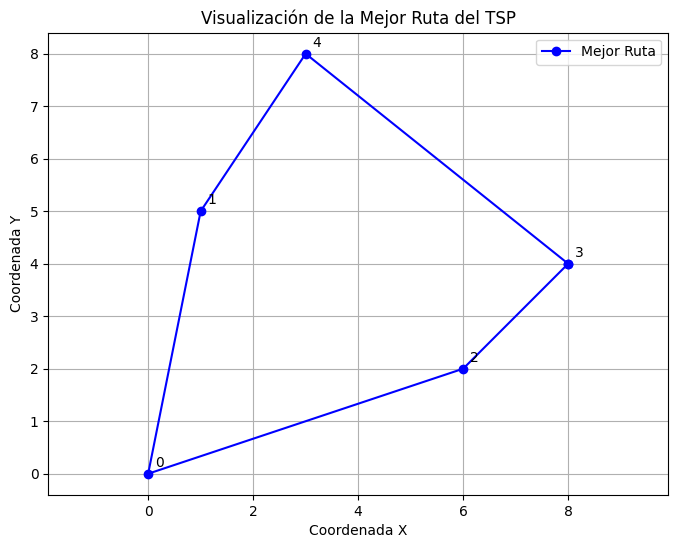

In [4]:
# Este bloque visualiza la mejor ruta encontrada en un plano 2D.

# Importamos el módulo pyplot de la librería matplotlib.
# pyplot proporciona una interfaz similar a MATLAB para crear gráficos.
# Lo importamos comúnmente con el alias 'plt'.
# NOTA: Esto requiere la librería externa matplotlib.
import matplotlib.pyplot as plt

# Aseguramos que tenemos una ruta para visualizar.
# Si ejecutaste el bloque del Algoritmo Genético, 'mejor_ruta_global' debe existir.
# Si solo ejecutaste Fuerza Bruta o Monte Carlo, podrías usar 'mejor_ruta_fb' o 'mejor_ruta_mc'.
# Vamos a usar 'mejor_ruta_global' del AG como ejemplo por defecto.
# Si no se ejecutó el AG, podrías descomentar las líneas siguientes para usar otra ruta encontrada:
# mejor_ruta_a_visualizar = mejor_ruta_fb # Usar la mejor ruta de Fuerza Bruta
# mejor_ruta_a_visualizar = mejor_ruta_mc # Usar la mejor ruta de Monte Carlo
# Asegúrate de que la variable de la ruta que quieres visualizar exista antes de este bloque.

# Para la visualización, usaremos la mejor ruta global encontrada por el AG.
ruta_a_visualizar = mejor_ruta_global # Usamos la variable que guarda el mejor resultado del AG

# --- Preparar los datos para el gráfico ---

# Obtenemos las coordenadas (x, y) de las ciudades en el orden de la ruta a visualizar.
# Creamos una lista vacía para guardar las coordenadas ordenadas.
coordenadas_ruta_ordenada = []
# Iteramos sobre los índices de ciudades en la ruta.
for indice_ciudad in ruta_a_visualizar:
    # Obtenemos la tupla de coordenadas (x, y) de la ciudad usando su índice.
    coordenadas_ciudad = ciudades[indice_ciudad]
    # Añadimos estas coordenadas a nuestra lista ordenada.
    coordenadas_ruta_ordenada.append(coordenadas_ciudad)

# Añadimos las coordenadas de la ciudad de inicio al final para cerrar el ciclo de la ruta.
# La primera ciudad de la ruta es ruta_a_visualizar[0].
coordenadas_ruta_ordenada.append(ciudades[ruta_a_visualizar[0]])

# Separamos las coordenadas x e y en dos listas diferentes, lo cual es útil para matplotlib.
# Creamos listas vacías para las coordenadas x e y.
x_coords = []
y_coords = []
# Iteramos sobre las coordenadas de la ruta ordenada.
for coord_x, coord_y in coordenadas_ruta_ordenada:
    # Añadimos la coordenada x a la lista x_coords.
    x_coords.append(coord_x)
    # Añadimos la coordenada y a la lista y_coords.
    y_coords.append(coord_y)

# --- Crear el Gráfico ---

# plt.figure() crea una nueva figura (ventana o área) para el gráfico.
plt.figure(figsize=(8, 6)) # figsize define el tamaño de la figura en pulgadas (ancho, alto).

# plt.plot(x, y, ...) dibuja líneas y/o marcadores.
# x_coords: lista de coordenadas x.
# y_coords: lista de coordenadas y.
# marker='o': Dibuja un círculo ('o') en cada punto (ciudad).
# linestyle='-': Dibuja una línea sólida ('-') conectando los puntos.
# color='blue': Dibuja las líneas y marcadores en color azul.
# label='Mejor Ruta': Añade una etiqueta para la leyenda del gráfico.
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='blue', label='Mejor Ruta')

# Opcional: Anotar cada ciudad con su índice original para identificarla.
# zip(ruta_a_visualizar, x_coords[:-1], y_coords[:-1]) itera sobre el índice de la ciudad y sus coordenadas (excepto el punto final repetido).
for i, x, y in zip(ruta_a_visualizar, x_coords[:-1], y_coords[:-1]):
    # plt.annotate() añade texto en el gráfico.
    # str(i): El texto a mostrar (el índice de la ciudad como string).
    # (x, y): Las coordenadas donde colocar el texto.
    # textcoords="offset points": Especifica que el offset se mide en puntos desde (x,y).
    # xytext=(5, 5): Desplaza el texto 5 puntos a la derecha y 5 puntos hacia arriba desde el punto (x,y).
    # ha='left' alinea el texto a la izquierda del punto de texto.
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(5, 5), ha='left')


# plt.title() establece el título del gráfico.
plt.title('Visualización de la Mejor Ruta del TSP')
# plt.xlabel() establece la etiqueta del eje x.
plt.xlabel('Coordenada X')
# plt.ylabel() establece la etiqueta del eje y.
plt.ylabel('Coordenada Y')
# plt.grid(True) muestra una cuadrícula en el gráfico para facilitar la lectura.
plt.grid(True)
# plt.legend() muestra la leyenda (si hay elementos con etiqueta).
plt.legend()

# plt.axis('equal') asegura que la escala de los ejes x e y sea la misma,
# para que las distancias se vean proporcionales.
plt.axis('equal')

# plt.show() muestra el gráfico. En Jupyter/Colab, a menudo no es estrictamente necesario
# si es la última línea del bloque, pero es una buena práctica incluirlo.
plt.show()